<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Custom Machine Learning engine

This notebook shows how to log the payload for the model deployed on custom model serving engine using Watson OpenScale python sdk.

Contents
- [1. Setup](#setup)
- [2. Binding machine learning engine](#binding)
- [3. Subscriptions](#subscription)
- [4. Scoring and payload logging](#scoring)
- [5. Feedback logging](#feedback)
- [6. Fairness monitoring](#fairness)
- [7. Working with Data Mart](#datamart)

<a id="setup"></a>
## 1. Setup

### 1.0 Sample custom machine learning engine

The sample machine learning engine based on docker image and deployment instructions can be found [here](https://github.com/pmservice/ai-openscale-tutorials/tree/master/applications/custom-ml-engine).

**NOTE:** CUSTOM machine learning engine must follow this [API specification](https://aiopenscale-custom-deployement-spec.mybluemix.net/) to be supported.

### 1.1 Installation and authentication

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1

Requirement not upgraded as not directly required: jmespath<1.0.0,>=0.7.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk-core==2.*,>=2.0.0->ibm-cos-sdk->watson-machine-learning-client->ibm-ai-openscale)


In [122]:
!pip install pyspark | tail -n 1
!pip install lime | tail -n 1

Import and initiate.

In [39]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.supporting_classes import PayloadRecord
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
import pandas as pd

#### ACTION: Get OpenScale `instance_guid` and `apikey`

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using bluemix console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

How to get your AI OpenScale instance GUID

- if your resource group is different than `default` switch to resource group containing AI OpenScale instance
```
bx target -g <myResourceGroup>
```
- get details of the instance
```
bx resource service-instance 'AI-OpenScale-instance_name'
```

#### Let's define some constants required to set up data mart:

- AIOS_CREDENTIALS
- POSTGRES_CREDENTIALS
- SCHEMA_NAME

In [4]:
AIOS_CREDENTIALS = {
  "url": "https://api.aiopenscale.cloud.ibm.com",
  "instance_guid": "***",
  "apikey": "***"
}

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
POSTGRES_CREDENTIALS = {
    "db_type": "postgresql",
    "uri_cli_1": "xxx",
    "maps": [],
    "instance_administration_api": {
        "instance_id": "xxx",
        "root": "xxx",
        "deployment_id": "xxx"
    },
    "name": "xxx",
    "uri_cli": "xxx",
    "uri_direct_1": "xxx",
    "ca_certificate_base64": "xxx",
    "deployment_id": "xxx",
    "uri": "xxx"
}

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
SCHEMA_NAME = 'data_mart_for_custom'

Create schema for data mart.

In [9]:
create_postgres_schema(postgres_credentials=POSTGRES_CREDENTIALS, schema_name=SCHEMA_NAME)

In [10]:
client = APIClient(AIOS_CREDENTIALS)

In [11]:
client.version

'2.0.6'

### 1.2 DataMart setup

In [13]:
client.data_mart.setup(db_credentials=POSTGRES_CREDENTIALS, schema=SCHEMA_NAME)

In [14]:
data_mart_details = client.data_mart.get_details()

<a id="binding"></a>
## 2. Bind machine learning engines

### 2.1 Bind  `CUSTOM` machine learning engine
**NOTE:** CUSTOM machine learning engine must follow this [API specification](https://aiopenscale-custom-deployement-spec.mybluemix.net/) to be supported.

Credentials support following fields:
- `url` - hostname and port (required)
- `username` - part of BasicAuth (optional)
- `password` - part of BasicAuth (optional)

In [15]:
CUSTOM_ENGINE_CREDENTIALS = {
    "url": "***",
    "username": "***",
    "password": "***"
}

In [16]:
# The code was removed by Watson Studio for sharing.

In [17]:
binding_uid = client.data_mart.bindings.add('My custom engine', CustomMachineLearningInstance(CUSTOM_ENGINE_CREDENTIALS))

In [18]:
bindings_details = client.data_mart.bindings.get_details()

In [19]:
client.data_mart.bindings.list()

d9535a46-d303-41c9-b7c1-3c4f719be1b5,My custom engine,custom_machine_learning,2019-02-05T12:30:41.744Z


<a id="subsciption"></a>
## 3. Subscriptions

### 3.1 Add subscriptions

List available deployments.

In [75]:
client.data_mart.bindings.list_assets()

credit,credit,2019-01-01T10:11:12Z,model,,d9535a46-d303-41c9-b7c1-3c4f719be1b5,False
resnet50,resnet50,2016-12-01T10:11:12Z,model,,d9535a46-d303-41c9-b7c1-3c4f719be1b5,False
action,area and action prediction,2016-12-01T10:11:12Z,model,,d9535a46-d303-41c9-b7c1-3c4f719be1b5,False


Let's specify training data information like: list of features and list of categorical features required by fairness and explain.

In [91]:
feature_columns = ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker']
categorical_columns = ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings', 'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty', 'InstallmentPlans','Housing', 'Job', 'Telephone', 'ForeignWorker']

In [94]:
subscription = client.data_mart.subscriptions.add(
    CustomMachineLearningAsset(
                source_uid='credit',
                label_column='Risk',
                prediction_column='prediction',
                probability_column='probability',
                feature_columns=feature_columns.copy(),
                categorical_columns=categorical_columns.copy(),
                binding_uid=binding_uid))

#### Get subscriptions list

In [95]:
subscriptions = client.data_mart.subscriptions.get_details()

In [96]:
subscriptions_uids = client.data_mart.subscriptions.get_uids()
print(subscriptions_uids)

['credit']


#### List subscriptions

In [97]:
client.data_mart.subscriptions.list()

credit,credit,model,d9535a46-d303-41c9-b7c1-3c4f719be1b5,2019-02-05T13:05:57.496Z


<a id="scoring"></a>
## 4. Scoring and payload logging

### 4.1 Score the credit model

In [98]:
import requests
import time

values = [
            ["no_checking", 13, "credits_paid_to_date", "car_new", 1343, "100_to_500", "1_to_4", 2, "female", "none", 3,
             "savings_insurance", 25, "none", "own", 2, "skilled", 1, "none", "yes"],
            ["no_checking", 24, "prior_payments_delayed", "furniture", 4567, "500_to_1000", "1_to_4", 4, "male", "none",
             4, "savings_insurance", 60, "none", "free", 2, "management_self-employed", 1, "none", "yes"],
            ["0_to_200", 26, "all_credits_paid_back", "car_new", 863, "less_100", "less_1", 2, "female", "co-applicant",
             2, "real_estate", 38, "none", "own", 1, "skilled", 1, "none", "yes"],
            ["0_to_200", 14, "no_credits", "car_new", 2368, "less_100", "1_to_4", 3, "female", "none", 3, "real_estate",
             29, "none", "own", 1, "skilled", 1, "none", "yes"],
            ["0_to_200", 4, "no_credits", "car_new", 250, "less_100", "unemployed", 2, "female", "none", 3,
             "real_estate", 23, "none", "rent", 1, "management_self-employed", 1, "none", "yes"],
            ["no_checking", 17, "credits_paid_to_date", "car_new", 832, "100_to_500", "1_to_4", 2, "male", "none", 2,
             "real_estate", 42, "none", "own", 1, "skilled", 1, "none", "yes"],
            ["no_checking", 50, "outstanding_credit", "appliances", 5696, "unknown", "greater_7", 4, "female",
             "co-applicant", 4, "unknown", 54, "none", "free", 2, "skilled", 1, "yes", "yes"],
            ["0_to_200", 13, "prior_payments_delayed", "retraining", 1375, "100_to_500", "4_to_7", 3, "male", "none", 3,
             "real_estate", 70, "none", "own", 2, "management_self-employed", 1, "none", "yes"]
        ]


request_data = {'fields': feature_columns, 'values': values}

header = {'Content-Type': 'application/json'}
scoring_url = subscription.get_details()['entity']['deployments'][0]['scoring_endpoint']['url']

start_time = time.time()
response = requests.post(scoring_url, json=request_data, headers=header)
response_time = int((time.time() - start_time)*1000)

response_data = response.json()
print('Response: ' + str(response_data))

Response: {'fields': ['prediction', 'probability'], 'labels': ['Risk', 'No Risk'], 'values': [['No Risk', [0.8823126094462725, 0.1176873905537274]], ['No Risk', [0.6755090846150376, 0.3244909153849625]], ['No Risk', [0.8944991421537971, 0.10550085784620292]], ['No Risk', [0.9297263621482206, 0.07027363785177945]], ['No Risk', [0.937346474163384, 0.06265352583661594]], ['No Risk', [0.8389265131291409, 0.16107348687085907]], ['Risk', [0.16270903114445467, 0.8372909688555453]], ['No Risk', [0.8011704003481404, 0.1988295996518596]]]}


### 4.2 Store the request and response in payload logging table

#### Using Python SDK

**Hint:** You can embed payload logging code into your custom deployment so it is logged automatically each time you score the model.

In [99]:
records_list = [PayloadRecord(request=request_data, response=response_data, response_time=response_time), 
                PayloadRecord(request=request_data, response=response_data, response_time=response_time)]

for i in range(1, 10):
    records_list.append(PayloadRecord(request=request_data, response=response_data, response_time=response_time))

subscription.payload_logging.store(records=records_list)

#### Using REST API

Get the token first.

In [100]:
token_endpoint = "https://iam.bluemix.net/identity/token"
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Accept": "application/json"
}

data = {
    "grant_type":"urn:ibm:params:oauth:grant-type:apikey",
    "apikey":AIOS_CREDENTIALS["apikey"]
}

req = requests.post(token_endpoint, data=data, headers=headers)
token = req.json()['access_token']

Store the payload.

In [101]:
import requests, uuid

PAYLOAD_STORING_HREF_PATTERN = '{}/v1/data_marts/{}/scoring_payloads'
endpoint = PAYLOAD_STORING_HREF_PATTERN.format(AIOS_CREDENTIALS['url'], AIOS_CREDENTIALS['data_mart_id'])

payload = [{
    'binding_id': binding_uid, 
    'deployment_id': subscription.get_details()['entity']['deployments'][0]['deployment_id'], 
    'subscription_id': subscription.uid, 
    'scoring_id': str(uuid.uuid4()), 
    'response': response_data,
    'request': request_data
}]


headers = {"Authorization": "Bearer " + token}
      
req_response = requests.post(endpoint, json=payload, headers = headers)

print("Request OK: " + str(req_response.ok))

Request OK: True


<a id="feedback"></a>
## 5. Feedback logging & quality (accuracy) monitoring

### Enable quality monitoring

You need to provide the monitoring `threshold` and `min_records` (minimal number of feedback records).

In [103]:
subscription.quality_monitoring.enable(threshold=0.7, min_records=10)

### Feedback records logging

Feedback records are used to evaluate your model. The predicted values are compared to real values (feedback records).

You can check the schema of feedback table using below method.

In [104]:
subscription.feedback_logging.print_table_schema()

CheckingStatus,string,True
LoanDuration,integer,True
CreditHistory,string,True
LoanPurpose,string,True
LoanAmount,integer,True
ExistingSavings,string,True
EmploymentDuration,string,True
InstallmentPercent,integer,True
Sex,string,True
OthersOnLoan,string,True
CurrentResidenceDuration,integer,True


The feedback records can be send to feedback table using below code.

In [106]:
records = []

fields = feature_columns.copy()
fields.append('Risk')

for i in range(1,20):
    records.append(["0_to_200", 18, "outstanding_credit", "car_new", 884, "less_100", "greater_7", 4, "male", "none", 4, "car_other", 36, "bank", "own", 1, "skilled", 2, "yes", "yes", "Risk"])

subscription.feedback_logging.store(feedback_data=records, fields=fields)

### Run quality monitoring on demand

By default, quality monitoring is run on hourly schedule. You can also trigger it on demand using below code.

In [107]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 01919dec-b011-414f-9185-87cf22d76ac5 




initializing
completed

---------------------------
 Successfully finished run 
---------------------------




### Show the quality metrics

In [108]:
subscription.quality_monitoring.show_table()

2019-02-05 12:30:55.889000+00:00,1.0,0.7,d9535a46-d303-41c9-b7c1-3c4f719be1b5,credit,german_credit_risk,Accuracy_evaluation_8b538e0b-a008-49f6-a38d-70c06e4dd73d,
2019-02-05 13:06:42.100000+00:00,1.0,0.7,d9535a46-d303-41c9-b7c1-3c4f719be1b5,credit,german_credit_risk,Accuracy_evaluation_01919dec-b011-414f-9185-87cf22d76ac5,


Get all calculated metrics.

In [109]:
subscription.quality_monitoring.get_metrics(deployment_uid='action')

{'end': '2019-02-05T13:06:52.794825Z',
 'metrics': [{'process': 'Accuracy_evaluation_8b538e0b-a008-49f6-a38d-70c06e4dd73d',
   'timestamp': '2019-02-05T12:30:55.889Z',
   'value': {'metrics': [{'name': 'areaUnderROC', 'value': 1.0},
     {'name': 'areaUnderPR', 'value': 1.0}],
    'quality': 1.0,
    'threshold': 0.7}},
  {'process': 'Accuracy_evaluation_01919dec-b011-414f-9185-87cf22d76ac5',
   'timestamp': '2019-02-05T13:06:42.100Z',
   'value': {'metrics': [{'name': 'areaUnderROC', 'value': 1.0},
     {'name': 'areaUnderPR', 'value': 1.0}],
    'quality': 1.0,
    'threshold': 0.7}}],
 'start': '2019-02-05T12:05:57.496Z'}

#### Get metrics as pandas dataframe

In [110]:
quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd

,ts,quality,quality_threshold,binding_id,subscription_id,deployment_id,process,asset_revision
0,2019-02-05 12:30:55.889000+00:00,1.0,0.7,d9535a46-d303-41c9-b7c1-3c4f719be1b5,credit,german_credit_risk,Accuracy_evaluation_8b538e0b-a008-49f6-a38d-70...,
1,2019-02-05 13:06:42.100000+00:00,1.0,0.7,d9535a46-d303-41c9-b7c1-3c4f719be1b5,credit,german_credit_risk,Accuracy_evaluation_01919dec-b011-414f-9185-87...,


Create a bar plot.

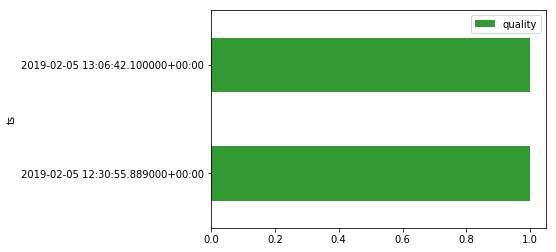

In [111]:
%matplotlib inline

quality_pd.plot.barh(x='ts', y='quality', color='g', alpha=0.8);

<a id="fairness"></a>
## 6. Fairness monitoring

### 6.1 Generate training data statistics for fairness monitoring

#### Get training data set from git

In [113]:
!wget https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spss/credit-risk/data/credit_risk_training.csv

--2019-02-05 13:10:28--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spss/credit-risk/data/credit_risk_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694222 (678K) [text/plain]
Saving to: ‘credit_risk_training.csv.1’

100%[======================================>] 694,222     --.-K/s   in 0.02s   

2019-02-05 13:10:29 (28.1 MB/s) - ‘credit_risk_training.csv.1’ saved [694222/694222]



In [114]:
data_df = pd.read_csv("credit_risk_training.csv",
                    dtype={'LoanDuration': int, 'LoanAmount': int, 'InstallmentPercent': int, 'CurrentResidenceDuration': int, 'Age': int, 'ExistingCreditsCount': int, 'Dependents': int})

#### Define properties required to calculate training data statistics 

In [119]:
fairness_properties = {
        "fairness_attributes": [
                        {
                            "majority": [[26,75]],
                            "minority": [[18,25]],
                            "type": "int",
                            "feature": "Age",
                            "threshold": 0.95
                        },
                        {
                            "majority": ["male"],
                            "minority": ["female"],
                            "type": "string",
                            "feature": "Sex",
                            "threshold": 0.95
                        }
                    ],
                    "min_records": 4,
                    "favourable_class": ['No Risk'],
                    "unfavourable_class": ['Risk']

                }

#### Build the data information object and execute

In [120]:
asset_properties = subscription.get_details()['entity']['asset_properties']

data_information = {
    "model_type": asset_properties['problem_type'],
    "class_label": asset_properties['label_column'],
    "feature_columns": asset_properties['feature_fields'], 
    "categorical_columns": asset_properties['categorical_fields'],
    "fairness_inputs": fairness_properties
}

In [123]:
from ibm_ai_openscale.utils.training_stats import TrainingStats

training_data_statistics = TrainingStats(data_df, data_information).get_training_statistics()

Total Rows retrieved 5000


### 6.2 Enable and run fairness monitoring

In [124]:
from ibm_ai_openscale.supporting_classes import Feature

subscription.fairness_monitoring.enable(
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26, 75]], minority=[[18, 25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=4,
            training_data_statistics=training_data_statistics
        )

In [131]:
from pandas.core.frame import DataFrame
type(data_df) is DataFrame

True

In [125]:
subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=german_credit_risk 




INITIATED
RUNNING
FINISHED

---------------------------
 Successfully finished run 
---------------------------




{'entity': {'parameters': {'class_label': 'prediction',
   'distributions': [{'attribute': 'Age',
     'class_labels': [{'counts': [{'class_value': 'No Risk', 'count': 36},
        {'class_value': 'Risk', 'count': 65}],
       'label': '[48, 49]'},
      {'counts': [{'class_value': 'No Risk', 'count': 17},
        {'class_value': 'Risk', 'count': 37}],
       'label': '[53, 54]'},
      {'counts': [{'class_value': 'No Risk', 'count': 393},
        {'class_value': 'Risk', 'count': 24}],
       'label': '[18, 19]'},
      {'counts': [{'class_value': 'No Risk', 'count': 2},
        {'class_value': 'Risk', 'count': 16}],
       'label': '[58, 59]'},
      {'counts': [{'class_value': 'No Risk', 'count': 93},
        {'class_value': 'Risk', 'count': 11}],
       'label': '[24, 25]'},
      {'counts': [{'class_value': 'No Risk', 'count': 5},
        {'class_value': 'Risk', 'count': 23}],
       'label': '[56, 57]'},
      {'counts': [{'class_value': 'No Risk', 'count': 90},
        {'class_va

#### Check fairness run results

In [126]:
subscription.fairness_monitoring.show_table()

2019-02-05 13:21:41.746578+00:00,Age,"[18, 25]",False,1.0,100.0,d9535a46-d303-41c9-b7c1-3c4f719be1b5,credit,credit,german_credit_risk,
2019-02-05 13:21:41.746578+00:00,Sex,female,False,1.0,100.0,d9535a46-d303-41c9-b7c1-3c4f719be1b5,credit,credit,german_credit_risk,
2019-02-05 13:22:18.101013+00:00,Age,"[18, 25]",False,1.0,100.0,d9535a46-d303-41c9-b7c1-3c4f719be1b5,credit,credit,german_credit_risk,
2019-02-05 13:22:18.101013+00:00,Sex,female,False,1.0,100.0,d9535a46-d303-41c9-b7c1-3c4f719be1b5,credit,credit,german_credit_risk,


<a id="datamart"></a>
## 7. Working with data mart

### 6.1 Payload logging

#### Print schema of payload_logging table

In [76]:
subscription.payload_logging.print_table_schema()

scoring_id,string,False
scoring_timestamp,timestamp,False
deployment_id,string,False
asset_revision,string,True
CheckingStatus,string,True
LoanDuration,integer,True
CreditHistory,string,True
LoanPurpose,string,True
LoanAmount,integer,True
ExistingSavings,string,True
EmploymentDuration,string,True


#### Show (preview) the table

In [77]:
subscription.payload_logging.describe_table()

       LoanDuration   LoanAmount  InstallmentPercent  \
count     64.000000    64.000000           64.000000   
mean      20.125000  2161.750000            2.750000   
std       13.097316  1841.937955            0.835711   
min        4.000000   250.000000            2.000000   
25%       13.000000   855.250000            2.000000   
50%       15.500000  1359.000000            2.500000   
75%       24.500000  2917.750000            3.250000   
max       50.000000  5696.000000            4.000000   

       CurrentResidenceDuration        Age  ExistingCreditsCount  Dependents  
count                 64.000000  64.000000             64.000000        64.0  
mean                   3.000000  42.625000              1.500000         1.0  
std                    0.712697  16.267116              0.503953         0.0  
min                    2.000000  23.000000              1.000000         1.0  
25%                    2.750000  28.000000              1.000000         1.0  
50%                  

#### Return the table content as pandas dataframe

In [78]:
pandas_df = subscription.payload_logging.get_table_content(format='pandas')

### 6.2 Feddback logging

Check the schema of table.

In [79]:
subscription.feedback_logging.print_table_schema()

CheckingStatus,string,True
LoanDuration,integer,True
CreditHistory,string,True
LoanPurpose,string,True
LoanAmount,integer,True
ExistingSavings,string,True
EmploymentDuration,string,True
InstallmentPercent,integer,True
Sex,string,True
OthersOnLoan,string,True
CurrentResidenceDuration,integer,True


Preview table content.

In [80]:
subscription.feedback_logging.show_table()

0_to_200,18,outstanding_credit,car_new,884,less_100,greater_7,4,male,none,4,car_other,36,bank,own,1,skilled,2,yes,yes,Risk,2019-02-05 10:50:48.408000+00:00
0_to_200,18,outstanding_credit,car_new,884,less_100,greater_7,4,male,none,4,car_other,36,bank,own,1,skilled,2,yes,yes,Risk,2019-02-05 10:50:48.408000+00:00
0_to_200,18,outstanding_credit,car_new,884,less_100,greater_7,4,male,none,4,car_other,36,bank,own,1,skilled,2,yes,yes,Risk,2019-02-05 10:50:48.408000+00:00
0_to_200,18,outstanding_credit,car_new,884,less_100,greater_7,4,male,none,4,car_other,36,bank,own,1,skilled,2,yes,yes,Risk,2019-02-05 10:50:48.408000+00:00
0_to_200,18,outstanding_credit,car_new,884,less_100,greater_7,4,male,none,4,car_other,36,bank,own,1,skilled,2,yes,yes,Risk,2019-02-05 10:50:48.408000+00:00
0_to_200,18,outstanding_credit,car_new,884,less_100,greater_7,4,male,none,4,car_other,36,bank,own,1,skilled,2,yes,yes,Risk,2019-02-05 10:50:48.408000+00:00
0_to_200,18,outstanding_credit,car_new,884,less_100,greater_7,4,male,none,4,car_other,36,bank,own,1,skilled,2,yes,yes,Risk,2019-02-05 10:50:48.408000+00:00
0_to_200,18,outstanding_credit,car_new,884,less_100,greater_7,4,male,none,4,car_other,36,bank,own,1,skilled,2,yes,yes,Risk,2019-02-05 10:50:48.408000+00:00
0_to_200,18,outstanding_credit,car_new,884,less_100,greater_7,4,male,none,4,car_other,36,bank,own,1,skilled,2,yes,yes,Risk,2019-02-05 10:50:48.408000+00:00
0_to_200,18,outstanding_credit,car_new,884,less_100,greater_7,4,male,none,4,car_other,36,bank,own,1,skilled,2,yes,yes,Risk,2019-02-05 10:51:19.408000+00:00


Describe table (calulcate basic statistics).

In [81]:
subscription.feedback_logging.describe_table()

       LoanDuration  LoanAmount  InstallmentPercent  CurrentResidenceDuration  \
count          28.0        28.0                28.0                      28.0   
mean           18.0       884.0                 4.0                       4.0   
std             0.0         0.0                 0.0                       0.0   
min            18.0       884.0                 4.0                       4.0   
25%            18.0       884.0                 4.0                       4.0   
50%            18.0       884.0                 4.0                       4.0   
75%            18.0       884.0                 4.0                       4.0   
max            18.0       884.0                 4.0                       4.0   

        Age  ExistingCreditsCount  Dependents  
count  28.0                  28.0        28.0  
mean   36.0                   1.0         2.0  
std     0.0                   0.0         0.0  
min    36.0                   1.0         2.0  
25%    36.0                   

Get table content.

In [82]:
feedback_pd = subscription.feedback_logging.get_table_content(format='pandas')

### 6.3 Quality metrics table

In [83]:
subscription.quality_monitoring.print_table_schema()

ts,timestamp,False
quality,float,False
quality_threshold,float,False
binding_id,string,False
subscription_id,string,False
deployment_id,string,True
process,string,False
asset_revision,string,True


In [84]:
subscription.quality_monitoring.show_table()

2019-02-05 10:51:21.711000+00:00,1.0,0.7,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,Accuracy_evaluation_3540fbc6-19c9-4c4a-a131-0f0ebfba8a26,
2019-02-05 11:02:25.824000+00:00,1.0,0.7,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,Accuracy_evaluation_7f813454-109d-4ff7-bc64-0e3f9b32615d,


### 6.4 Performance metrics table

In [85]:
subscription.performance_monitoring.print_table_schema()

ts,timestamp,False
scoring_time,float,False
scoring_records,object,False
binding_id,string,False
subscription_id,string,False
deployment_id,string,True
process,string,False
asset_revision,string,True


In [86]:
subscription.performance_monitoring.show_table()

2019-02-05 10:48:21.297089+00:00,19.0,8,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,,
2019-02-05 10:48:21.297142+00:00,19.0,8,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,,
2019-02-05 10:48:21.297237+00:00,19.0,8,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,,
2019-02-05 10:48:21.297254+00:00,19.0,8,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,,
2019-02-05 10:48:21.297205+00:00,19.0,8,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,,
2019-02-05 10:48:21.297302+00:00,19.0,8,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,,
2019-02-05 10:48:21.297164+00:00,19.0,8,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,,
2019-02-05 10:48:21.297270+00:00,19.0,8,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,,
2019-02-05 10:48:21.297221+00:00,19.0,8,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,,
2019-02-05 10:48:21.297189+00:00,19.0,8,cb00fa1b-e441-4b34-b599-dcee7cad6f62,credit,german_credit_risk,,


### 6.5 Data Mart measurement facts table

In [87]:
client.data_mart.get_deployment_metrics()

{'deployment_metrics': [{'asset': {'asset_id': 'credit',
    'asset_type': 'model',
    'created_at': '2019-01-01T10:11:12Z',
    'name': 'credit',
    'url': 'http://169.63.194.147:31520/v1/deployments/credit/online'},
   'deployment': {'created_at': '2019-01-01T10:11:12Z',
    'deployment_id': 'german_credit_risk',
    'deployment_rn': '',
    'deployment_type': 'online',
    'name': 'German credit risk compliant deployment',
    'scoring_endpoint': {'request_headers': {'Content-Type': 'application/json'},
     'url': 'http://169.63.194.147:31520/v1/deployments/credit/online'},
    'url': ''},
   'metrics': [{'issues': 0,
     'metric_type': 'performance',
     'timestamp': '2019-02-05T10:48:21.297302Z',
     'value': {'records': 8, 'response_time': 19.0}},
    {'issues': 0,
     'metric_type': 'quality',
     'timestamp': '2019-02-05T11:02:25.824Z',
     'value': {'metrics': [{'name': 'areaUnderROC', 'value': 1.0},
       {'name': 'areaUnderPR', 'value': 1.0}],
      'quality': 1.0,

---

### Authors
Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.